## Fetch data

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import utm
import scipy
import scipy.interpolate
import scipy.signal
from scipy.spatial.transform import Rotation
# from car_dynamics.envs.kinematic_bicycle_model import LF, LR
from car_dynamics.analysis import pos2vel_savgol, calc_delta, interpolate, rotate_point
from offroad.utils import load_state
import ipywidgets as widgets
from ipywidgets import interact
from termcolor import colored
%matplotlib inline
%load_ext autoreload
%autoreload 2

LF = .16
LR = .15

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:

log_dir = '/Users/wenlixiao/Desktop/offroad/' + 'data/data-20240105-131330'

In [7]:
ORIENTATION_PROVIDOER = 'imu'
t_list, p_dict, yaw_dict, action_list = load_state(log_dir, [0, 3], orientation_provider=ORIENTATION_PROVIDOER)
yaw_list = yaw_dict['zed2']
p_list = p_dict['gps']
yaw_ang_vel = yaw_dict['zed2_ang_vel']
# vesc_ang_vel = yaw_dict['vesc_ang_vel']
# yaw_list = yaw_dict['vesc']

Output()

[INFO] In total 3 logs


## Calibrate Coordinate and Yaw

### rotation angle

In [8]:
# Find the rotation angle
# 195 for playground near the East Garage
def p(angle=195):
    px, py = rotate_point(p_list[:, 0], p_list[:, 1], angle)
    plt.scatter(px[0],py[0])
    plt.scatter(px[-1],py[-1], marker='*')
    plt.plot(px, py)
    # plt.xlim([-50,10])
    # plt.ylim([-50,10])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
interact(p, 
          angle=(0,360,5)
        )

interactive(children=(IntSlider(value=195, description='angle', max=360, step=5), Output()), _dom_classes=('wi…

<function __main__.p(angle=195)>

In [9]:
px, py = rotate_point(p_list[:, 0], p_list[:, 1], 195)
p_rot = np.zeros((len(px),2))
p_rot[:,0] = px
p_rot[:,1] = py

TypeError: list indices must be integers or slices, not tuple

### yaw

In [435]:
def plot(yaw_offset=0.0):
    yaw_norm = yaw_list + yaw_offset
    yaw_norm = np.arctan2(np.sin(yaw_norm), np.cos(yaw_norm))
    # plt.plot(yaw_list + yaw_offset)
    plt.plot(yaw_norm)
    plt.plot(np.zeros_like(yaw_norm), color='red')
interact(plot, yaw_offset=(-np.pi,np.pi,0.005),)
# p_smooth, vel = pos2vel_savgol(p_rot,window_length=5, delta=dt)
# delta, beta = calc_delta(state)
# delta, beta = calc_delta(p_smooth, yaw_list+0.2171, LF, LR)

interactive(children=(FloatSlider(value=0.0, description='yaw_offset', max=3.141592653589793, min=-3.141592653…

<function __main__.plot(yaw_offset=0.0)>

In [436]:
yaw_calibrated = yaw_list - 1.73

### Yaw predict

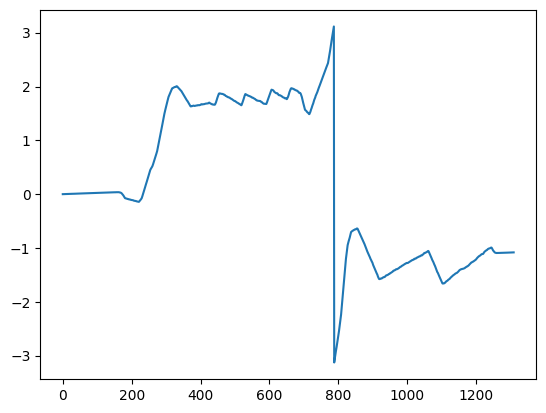

In [437]:
constant_err = 0.0007
yaw_pred = []
yaw_pred.append(0.0)
for i in range(len(t_list)-1):
    dt = t_list[i+1]-t_list[i]
    yaw_pred.append(yaw_pred[-1] + dt * yaw_ang_vel[i] + constant_err) 
yaw_pred = np.array(yaw_pred)
yaw_pred = np.arctan2(np.sin(yaw_pred), np.cos(yaw_pred))
plt.plot(yaw_pred)

## Input to target error

In [444]:
def plot_input_to_target_error(p_list, yaw_list, action_list, LF, LR, speed_max=8., 
                               steer_max=.34,delta_offset = -1.6, frequency=20, delta_proj=-1.32,st=0,ed=-1,):
    '''Error between 
        - vel_real and vel_target
        - steer_real and steer_target          
    '''
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # frequency = 20
    dt = 1./frequency
    print(dt)
    # t = np.arange(0, len(p_list)*dt, dt)
    # t_20hz, state_20hz = interpolation(data[:,-1],data, frequency=frequency)
    # state, vel = pos2vel_savgol(state_20hz,window_length=5)
    # delta, beta = calc_delta(state)
    p_smooth, vel = pos2vel_savgol(p_list,window_length=5, delta=dt)
    # vel = []
    # for i in range(1, len(p_list), 1):
    #     dist = np.linalg.norm(p_list[i] - p_list[i-1])
    #     t_step = t_list[i]-t_list[i-1]
    #     vel.append(dist/t_step)
        
    delta, beta = calc_delta(p_smooth, yaw_list, LF, LR)
    
    vel_real = vel[st:ed]
    vel_tar = action_list[st:ed, 0]*speed_max
    delta_real = delta[st:ed]
    # delta_tar = np.clip(action_list[st:ed, 1]*delta_proj + delta_offset, -steer_max, steer_max)
    delta_tar = action_list[st:ed, 1]*delta_proj + delta_offset
    # delta_tar = action_list[st:ed, 1]
    # delta_tar = np.arctan2(np.sin(delta_tar), np.cos(delta_tar))
    delta_tar = delta_tar[:-1]
    axs[0].plot(vel_real,label='real')
    axs[0].plot(vel_tar,label='target')
    axs[0].set_xlabel(f"frequency: {frequency}, orientation by {ORIENTATION_PROVIDOER}")

    axs[1].plot(delta_real,label='real')
    axs[1].plot(delta_tar,label='target')
    axs[0].set_title("velocity")
    axs[1].set_title("steering")
    axs[0].legend()
    axs[1].legend()
    plt.suptitle("Command (vel, steering) to real error (RTK input)\n" + log_dir)
    # print(colored(f'MSE Vel:   {np.mean((vel_real - vel_tar)**2)}','green'))
    # print(colored(f'MSE Steer: {np.mean((delta_real - delta_tar)**2)}','green'))

In [445]:
f = lambda st=0,ed=-1, frequency=22, speed_max=6.0, steer_max=.34, delta_offset=-0.2, delta_proj=-0.2: plot_input_to_target_error(
                                                p_rot, yaw_pred, action_list, LF, LR, delta_proj=delta_proj,
                                                speed_max=speed_max, steer_max=steer_max,delta_offset = delta_offset, frequency=frequency,
                                                st=st,ed=ed)
interact(f, frequency=(1, 100, 1),
            speed_max=(4., 8., 0.1), 
            steer_max=(0.2, 0.8, 0.01),
            delta_offset=(-np.pi, np.pi, 0.01),
             delta_proj=(-2., 2., 0.1),
             st=(0,1000,1),
             ed=(-1000,0,1),
        )

interactive(children=(IntSlider(value=0, description='st', max=1000), IntSlider(value=-1, description='ed', ma…

<function __main__.<lambda>(st=0, ed=-1, frequency=22, speed_max=6.0, steer_max=0.34, delta_offset=-0.2, delta_proj=-0.2)>

## Open Loop Trajectory

In [416]:
def plot_open_loop_trajectory(p_list, yaw_list, action_list, LF, LR, speed_max=8., st=0, ed=-1,
                               steer_max=.34,delta_offset = -1.6, frequency=22, delta_proj=-1.32, beta_offset=0.1, vel_type='target vel', 
                              steer_type='target steer', real_yaw=False,):
    dt = 1./frequency
    # t_20hz, state_20hz = interpolation(data[:,-1],data, frequency=frequency)
    # state, vel = pos2vel_savgol(state_20hz,window_length=5)
    p_smooth, vel = pos2vel_savgol(p_list,window_length=5, delta=dt)
    # delta, beta = calc_delta(state)
    delta, beta = calc_delta(p_smooth, yaw_list, LF, LR)
   
    vel_tar = action_list[:, 0]*speed_max
    delta_tar = action_list[:, 1]*delta_proj + delta_offset
    delta_tar = np.arctan2(np.sin(delta_tar), np.cos(delta_tar))

    
    if vel_type != 'real vel':
        vel = vel_tar

    if steer_type != 'real steer':
        delta = delta_tar
        
    x = p_list[st, 0]
    y = p_list[st, 1]
    x_list = [x]
    y_list = [y]
    psi = yaw_list[st]
    delta_list = [delta[st]]
    
    # print(state[1:3]-state[0:2])
    for v_t, beta_t_ground, delta_t, yaw_t in zip(vel[st:ed], beta[st:ed], delta[st:ed], yaw_list[st:ed]):
        if real_yaw:
            beta_t = beta_t_ground
        else:
            beta_t = np.arctan2(np.tan(delta_t)*LR,(LF+LR))
        dx = v_t * np.cos(yaw_t + beta_t) * dt
        dy = v_t * np.sin(yaw_t + beta_t) * dt
        
        x += dx
        y += dy
        x_list.append(x)
        y_list.append(y)
        delta_list.append(delta_t)
        
    print(len(p_list[st:ed]))
    # t = t_20hz[:-1]
    # plt.title(f"Trajectory: {EXP_TYPE}")
    plt.scatter(x_list,y_list, c='green',s=2,marker='o', label='predict')
    # plt.xlim([-60,0])
    plt.scatter(p_list[st:ed,0],p_list[st:ed,1], c='red', alpha=0.5, s=2, label='ground truth')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Open Loop Trajectory (RTK input)\n"+log_dir)
    plt.legend()

In [417]:
f = lambda steer_type='real steer', vel_type='real vel', real_yaw=False, st=0, ed=-1, frequency=20, speed_max=6.1, steer_max=.34, \
            delta_offset=-1.35, beta_offset=0.0, delta_proj=-1.3: plot_open_loop_trajectory(p_rot, yaw_pred, action_list, 
                                                                            LF, LR, delta_proj=delta_proj,
                                                speed_max=speed_max, steer_max=steer_max,delta_offset = delta_offset, frequency=frequency,
                                                steer_type=steer_type, vel_type=vel_type, real_yaw=real_yaw, st=st,ed=ed,beta_offset=beta_offset)

interact(f, 
                     real_yaw=[True,False],
                     vel_type=['real vel',  'target vel'],
                    steer_type = ['real steer', 'target steer'],
                     frequency=(1, 100, 1),
                    speed_max=(4., 10., 0.1), 
                    steer_max=(0.2, 0.8, 0.01),
                    delta_offset=(-np.pi, np.pi, 0.01),
                     delta_proj=(-2., 2, 0.01),
                    st=(0, 2000, 1),
                     ed=(-1000, -1, 1),
                     beta_offset = (-np.pi,np.pi,0.01),
        )

interactive(children=(Dropdown(description='steer_type', options=('real steer', 'target steer'), value='real s…

<function __main__.<lambda>(steer_type='real steer', vel_type='real vel', real_yaw=False, st=0, ed=-1, frequency=20, speed_max=6.1, steer_max=0.34, delta_offset=-1.35, beta_offset=0.0, delta_proj=-1.3)>

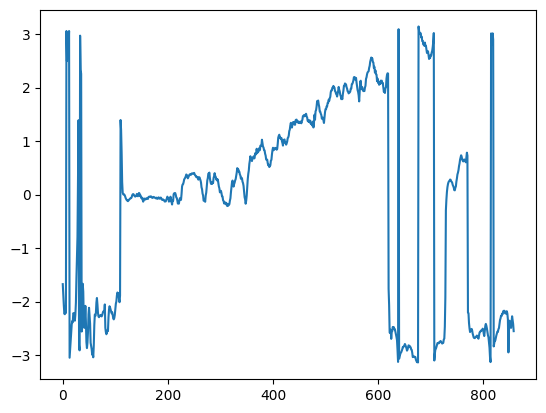

In [16]:
import math
dt = 0.05
p_smooth, vel = pos2vel_savgol(p_rot,window_length=5, delta=dt)
# delta, beta = calc_delta(state)
delta, beta = calc_delta(p_smooth, yaw_calibrated, LF, LR)
beta_new = []
for b in beta :
    while b>math.pi:
        b-=2*math.pi
    while b <-math.pi:
        b+=2*math.pi
    beta_new.append(b)
plt.plot(beta_new)

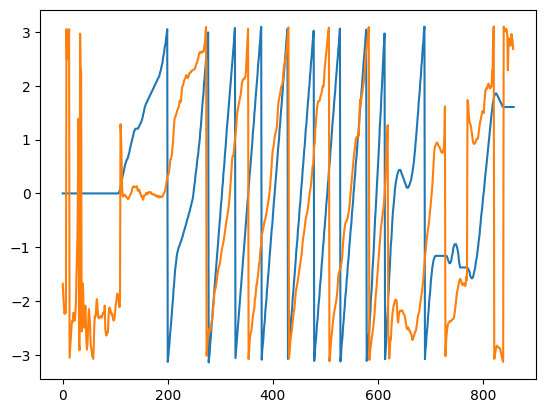

In [28]:
yaw_calibrated = np.arctan2(np.sin(yaw_calibrated), np.cos(yaw_calibrated))
plt.plot(yaw_calibrated)

plt.plot(np.arctan2(p_smooth[1:,1]-p_smooth[:-1,1],p_smooth[1:,0]-p_smooth[:-1,0]))

# With Vicon data

## Fetch data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import utm
import scipy
import scipy.interpolate
import scipy.signal
from scipy.spatial.transform import Rotation
# from car_dynamics.envs.kinematic_bicycle_model import LF, LR
from car_dynamics.analysis import pos2vel_savgol, calc_delta, interpolate, rotate_point, calc_delta_v
from offroad.utils import load_state
import ipywidgets as widgets
from ipywidgets import interact
from termcolor import colored
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
log_dir = '/Users/wenlixiao/Desktop/offroad/' + 'data/data-20240110-213110'


In [4]:
ORIENTATION_PROVIDOER = 'imu'
t_list, p_dict, yaw_dict, action_list, _ = load_state(log_dir, [0, 72], orientation_provider=ORIENTATION_PROVIDOER)
yaw_vicon = yaw_dict['vicon']
# yaw_zed2 = yaw_dict['zed2']
# yaw_ang_vel = yaw_dict['zed2_ang_vel']
# vesc_ang_vel = yaw_dict['vesc_ang_vel']
p_list = p_dict['vicon']
# yaw_list = yaw_dict['vesc']


Output()

[INFO] In total 72 logs


## Calibrate

### rotation angle

In [6]:
# Find the rotation angle
# 195 for playground near the East Garage
def p(angle=90):
    px, py = rotate_point(p_list[:, 0], p_list[:, 1], angle)
    plt.scatter(px[0],py[0])
    plt.scatter(px[-1],py[-1], marker='*')
    plt.plot(px, py)
    # plt.xlim([-50,10])
    # plt.ylim([-50,10])
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
interact(p, 
          angle=(0,360,5)
        )

interactive(children=(IntSlider(value=90, description='angle', max=360, step=5), Output()), _dom_classes=('wid…

<function __main__.p(angle=90)>

In [7]:
px, py = rotate_point(p_list[:, 0], p_list[:, 1], 90)
p_rot = np.zeros((len(px),2))
p_rot[:,0] = px
p_rot[:,1] = py

### yaw vicon

In [8]:
def plot(yaw_offset=np.pi/2):
    yaw_norm = yaw_vicon + yaw_offset
    yaw_norm = np.arctan2(np.sin(yaw_norm), np.cos(yaw_norm))
    # plt.plo/t(yaw_list + yaw_offset)
    plt.plot(yaw_norm)
    plt.plot(np.zeros_like(yaw_norm), color='red')
interact(plot, yaw_offset=(-np.pi,np.pi,0.005),)
# p_smooth, vel = pos2vel_savgol(p_rot,window_length=5, delta=dt)
# delta, beta = calc_delta(state)
# delta, beta = calc_delta(p_smooth, yaw_list+0.2171, LF, LR)

interactive(children=(FloatSlider(value=1.5707963267948966, description='yaw_offset', max=3.141592653589793, m…

<function __main__.plot(yaw_offset=1.5707963267948966)>

In [9]:
yaw_vicon_calibrated = yaw_vicon + np.pi/2
yaw_vicon_calibrated = np.arctan2(np.sin(yaw_vicon_calibrated), np.cos(yaw_vicon_calibrated))

### yaw zed2

In [8]:
def plot(yaw_offset=0.0):
    yaw_norm = yaw_zed2 + yaw_offset
    yaw_norm = np.arctan2(np.sin(yaw_norm), np.cos(yaw_norm))
    # plt.plo/t(yaw_list + yaw_offset)
    plt.plot(yaw_norm)
    plt.plot(np.zeros_like(yaw_norm), color='red')
interact(plot, yaw_offset=(-np.pi,np.pi,0.005),)
# p_smooth, vel = pos2vel_savgol(p_rot,window_length=5, delta=dt)
# delta, beta = calc_delta(state)
# delta, beta = calc_delta(p_smooth, yaw_list+0.2171, LF, LR)

interactive(children=(FloatSlider(value=0.0, description='yaw_offset', max=3.141592653589793, min=-3.141592653…

<function __main__.plot(yaw_offset=0.0)>

In [9]:
yaw_zed2_calibrated = yaw_zed2 + 0.15
yaw_zed2_calibrated = np.arctan2(np.sin(yaw_zed2_calibrated), np.cos(yaw_zed2_calibrated))

NameError: name 'yaw_zed2' is not defined

### compare yaw vicon <-> zed2

In [10]:
constant_err = 0.0007
yaw_pred = []
yaw_pred.append(yaw_vicon_calibrated[0])
for i in range(len(t_list)-1):
    dt = t_list[i+1]-t_list[i]
    yaw_pred.append(yaw_pred[-1] + dt * yaw_ang_vel[i] + constant_err) 
yaw_pred = np.array(yaw_pred)
yaw_pred = np.arctan2(np.sin(yaw_pred), np.cos(yaw_pred))
plt.plot(yaw_pred)

NameError: name 'yaw_ang_vel' is not defined

Text(0, 0.5, 'angle')

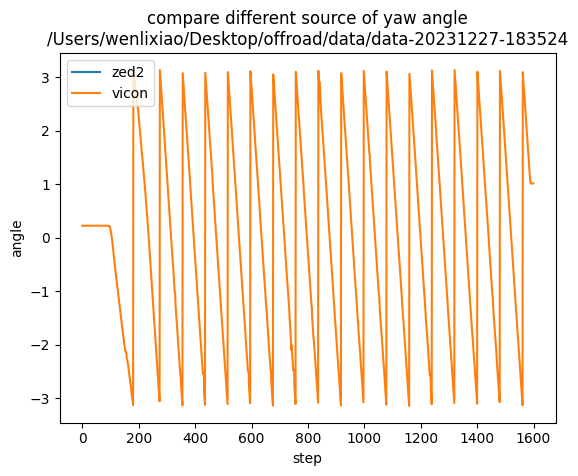

In [11]:
# plt.plot(yaw_zed2_calibrated, label='zed2')
plt.plot(yaw_pred, label='zed2')
plt.plot(yaw_vicon_calibrated, label='vicon')
plt.legend()
plt.title("compare different source of yaw angle\n"+log_dir)
plt.xlabel("step")
plt.ylabel("angle")

In [12]:

P = np.array([[1.0]])                   # initial estimation error covariance

# Process Noise
Q = np.array([[0.001]])

# Measurement Matrix
H = np.array([[1]])

# Measurement Noise
R = np.array([[0.001]])

# Identity Matrix
I = np.identity(1)

kf_yaw = []
x = np.array([[yaw_vicon_calibrated[0]]])
for i in range(len(t_list)):
    # Time step
    if i == 0:
        dt = 0
    else:
        dt = t_list[i] - t_list[i-1]

    # Prediction Step
    F = np.array([[1]])  # State transition matrix
    x = np.dot(F, x) + yaw_ang_vel[i] * dt  # State update with yaw velocity
    P = np.dot(F, np.dot(P, F.T)) + Q

    # Update Step
    Z = np.array([[yaw_vicon_calibrated[i]]])
    y = Z - np.dot(H, x)  # Measurement residual
    S = np.dot(H, np.dot(P, H.T)) + R
    K = np.dot(P, np.dot(H.T, np.linalg.inv(S)))
    x = x + np.dot(K, y)
    P = np.dot((I - np.dot(K, H)), P)

    kf_yaw.append(x[0,0])

kf_yaw = np.array(kf_yaw)
print(P, Q)

NameError: name 'yaw_ang_vel' is not defined

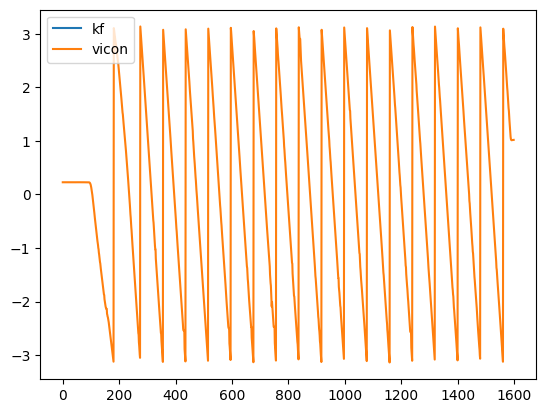

In [13]:
plt.plot(kf_yaw,label='kf')
plt.plot(yaw_vicon_calibrated, label='vicon')
plt.legend()

### Predicting

In [14]:
P = np.array([[0.00061803]])  # Adjust based on previous tuning
Q = np.array([[0.001]])
x = np.array([[yaw_vicon_calibrated[0]]])
kf_yaw_pred = []
for i in range(len(t_list)):
    # Time step
    if i == 0:
        dt = 0
    else:
        dt = t_list[i] - t_list[i-1]

    # Prediction Step
    F = np.array([[1]])  # State transition matrix
    x = np.dot(F, x) + yaw_ang_vel[i] * dt
    P = np.dot(F, np.dot(P, F.T)) + Q

    kf_yaw_pred.append(x[0,0])
kf_yaw_pred = np.array(kf_yaw_pred)
kf_yaw_pred = np.arctan2(np.sin(kf_yaw_pred), np.cos(kf_yaw_pred))


NameError: name 'yaw_ang_vel' is not defined

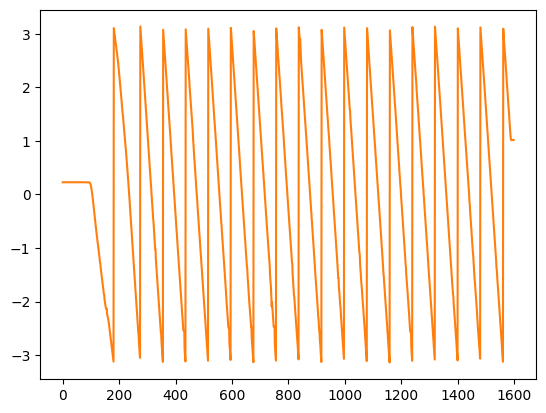

In [15]:
plt.plot(kf_yaw_pred)
plt.plot(yaw_vicon_calibrated)

In [16]:

diff = kf_yaw_pred - yaw_vicon_calibrated
diff_norm = np.arctan2(np.sin(diff), np.cos(diff))
plt.plot(diff_norm)
plt.title("error between Yaw_vicon and Yaw_imu")

ValueError: operands could not be broadcast together with shapes (0,) (1600,) 

In [17]:
np.savetxt('real_yaw.txt', yaw_vicon_calibrated)
np.savetxt('yaw_ang_vel.txt', yaw_ang_vel)
np.savetxt('time.txt', t_list)

NameError: name 'yaw_ang_vel' is not defined

## Input to target error

In [13]:
def plot_input_to_target_error(p_list, yaw_list, action_list, LF, LR, speed_max=8., 
                               steer_max=.34,delta_offset = -1.6, frequency=20, delta_proj=-1.32,st=0,ed=-1,):
    '''Error between 
        - vel_real and vel_target
        - steer_real and steer_target          
    '''
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # frequency = 20
    dt = 1./frequency
    print(dt)
    # t = np.arange(0, len(p_list)*dt, dt)
    # t_20hz, state_20hz = interpolation(data[:,-1],data, frequency=frequency)
    # state, vel = pos2vel_savgol(state_20hz,window_length=5)
    # delta, beta = calc_delta(state)
    p_smooth, vel, vel_vec = pos2vel_savgol(p_list,window_length=5, delta=dt)
    # vel = []
    # for i in range(1, len(p_list), 1):
    #     dist = np.linalg.norm(p_list[i] - p_list[i-1])
    #     t_step = t_list[i]-t_list[i-1]
    #     vel.append(dist/t_step)
    
    # delta, beta = calc_delta(p_smooth, yaw_list, LF, LR)
    delta, beta = calc_delta_v(vel_vec, yaw_list, LF, LR)
    
    vel_real = vel[st:ed]
    vel_tar = action_list[st:ed, 0]*speed_max
    delta_real = delta[st:ed]
    # delta_tar = np.clip(action_list[st:ed, 1]*delta_proj + delta_offset, -steer_max, steer_max)
    delta_tar = action_list[st:ed, 1]*delta_proj + delta_offset
    # delta_tar = action_list[st:ed, 1]
    # delta_tar = np.arctan2(np.sin(delta_tar), np.cos(delta_tar))
    delta_tar = delta_tar[:-1]
    axs[0].plot(vel_real,label='real')
    axs[0].plot(vel_tar,label='target')
    axs[0].set_xlabel(f"frequency: {frequency}")

    axs[1].plot(delta_real,label='real')
    axs[1].plot(delta_tar,label='target')
    axs[0].set_title("velocity")
    axs[1].set_title("steering")
    axs[0].legend()
    axs[1].legend()
    plt.suptitle("Command (vel, steering) to real error (Vicon input)\n" + log_dir)
    # print(colored(f'MSE Vel:   {np.mean((vel_real - vel_tar)**2)}','green'))
    # print(colored(f'MSE Steer: {np.mean((delta_real - delta_tar)**2)}','green'))

In [14]:
f = lambda st=100,ed=-60, frequency=22, speed_max=6.0, steer_max=.34, delta_offset=-0.2, delta_proj=-0.2: plot_input_to_target_error(
                                                p_rot, yaw_vicon_calibrated, action_list, LF, LR, delta_proj=delta_proj,
                                                speed_max=speed_max, steer_max=steer_max,delta_offset = delta_offset, frequency=frequency,
                                                st=st,ed=ed)
interact(f, frequency=(1, 100, 1),
            speed_max=(4., 8., 0.1), 
            steer_max=(0.2, 0.8, 0.01),
            delta_offset=(-np.pi, np.pi, 0.01),
             delta_proj=(-2., 2., 0.1),
             st=(0,1000,1),
             ed=(-1000,0,1),
        )

interactive(children=(IntSlider(value=100, description='st', max=1000), IntSlider(value=-60, description='ed',…

<function __main__.<lambda>(st=100, ed=-60, frequency=22, speed_max=6.0, steer_max=0.34, delta_offset=-0.2, delta_proj=-0.2)>

## Open Loop trajectory

In [15]:
def plot_open_loop_trajectory(p_list, yaw_list, action_list, LF, LR, speed_max=8., st=0, ed=-1,
                               steer_max=.34,delta_offset = -1.6, frequency=22, delta_proj=-1.32, beta_offset=0.1, vel_type='target vel', 
                              steer_type='target steer', real_yaw=False,):
    dt = 1./frequency
    # t_20hz, state_20hz = interpolation(data[:,-1],data, frequency=frequency)
    # state, vel = pos2vel_savgol(state_20hz,window_length=5)
    p_smooth, vel, vel_vec = pos2vel_savgol(p_list,window_length=5, delta=dt)
    # delta, beta = calc_delta(state)
    delta, beta = calc_delta(p_smooth, yaw_list, LF, LR)
   
    vel_tar = action_list[:, 0]*speed_max
    delta_tar = action_list[:, 1]*delta_proj + delta_offset
    delta_tar = np.arctan2(np.sin(delta_tar), np.cos(delta_tar))

    
    if vel_type != 'real vel':
        vel = vel_tar

    if steer_type != 'real steer':
        delta = delta_tar
        
    x = p_list[st, 0]
    y = p_list[st, 1]
    x_list = [x]
    y_list = [y]
    psi = yaw_list[st]
    delta_list = [delta[st]]
    
    # print(state[1:3]-state[0:2])
    for i, (v_t, beta_t_ground, delta_t, yaw_t) in enumerate(zip(vel[st:ed], beta[st:ed], delta[st:ed], yaw_list[st:ed])):
        if real_yaw:
            beta_t = beta_t_ground
        else:
            beta_t = np.arctan2(np.tan(delta_t)*LR,(LF+LR))

        # dt = t_list[i+1]-t_list[i]
        dx = v_t * np.cos(yaw_t + beta_t) * dt
        dy = v_t * np.sin(yaw_t + beta_t) * dt
        
        x += dx
        y += dy
        x_list.append(x)
        y_list.append(y)
        delta_list.append(delta_t)
        
    print(len(p_list[st:ed]))
    # t = t_20hz[:-1]
    # plt.title(f"Trajectory: {EXP_TYPE}")
    plt.scatter(x_list,y_list, c='green',s=2,marker='o', label='predict')
    # plt.xlim([-60,0])
    plt.scatter(p_smooth[st:ed,0],p_smooth[st:ed,1], c='red', alpha=0.5, s=2, label='ground truth')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title("Open Loop Trajectory (Vicon input)\n"+log_dir)
    plt.legend()

In [16]:
f = lambda steer_type='real steer', vel_type='real vel', real_yaw=False, st=0, ed=-1, frequency=22, speed_max=6.1, steer_max=.34, \
            delta_offset=-1.35, beta_offset=0.0, delta_proj=-1.3: plot_open_loop_trajectory(p_rot, yaw_vicon_calibrated, action_list, 
                                                                            LF, LR, delta_proj=delta_proj,
                                                speed_max=speed_max, steer_max=steer_max,delta_offset = delta_offset, frequency=frequency,
                                                steer_type=steer_type, vel_type=vel_type, real_yaw=real_yaw, st=st,ed=ed,beta_offset=beta_offset)

interact(f, 
                     real_yaw=[True,False],
                     vel_type=['real vel',  'target vel'],
                    steer_type = ['real steer', 'target steer'],
                     frequency=(1, 100, 1),
                    speed_max=(4., 8., 0.1), 
                    steer_max=(0.2, 0.8, 0.01),
                    delta_offset=(-np.pi, np.pi, 0.01),
                     delta_proj=(-2., 2, 0.01),
                    st=(0, 2000, 1),
                     ed=(-1000, -1, 1),
                     beta_offset = (-np.pi,np.pi,0.01),
        )

interactive(children=(Dropdown(description='steer_type', options=('real steer', 'target steer'), value='real s…

<function __main__.<lambda>(steer_type='real steer', vel_type='real vel', real_yaw=False, st=0, ed=-1, frequency=22, speed_max=6.1, steer_max=0.34, delta_offset=-1.35, beta_offset=0.0, delta_proj=-1.3)>